## M0 : Quick Start track B **AG News**

### Confirm GPU is ready

In [1]:
!nvidia-smi || echo "nvidia-smi unavailable (CPU runtime)"

Sat Nov 22 16:49:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 577.03                 Driver Version: 577.03         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              2W /   50W |     790MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Point the notebook at the project folder

In [2]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()
elif PROJECT_ROOT.name == "content":
    candidate = PROJECT_ROOT / "nlp-project"
    if candidate.exists():
        PROJECT_ROOT = candidate.resolve()

if not (PROJECT_ROOT / "src").exists():
    raise FileNotFoundError(
        f"Could not locate project root at {PROJECT_ROOT}. Upload or clone nlp-project before proceeding."
    )

os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))
print(f"Project root: {PROJECT_ROOT}")


Project root: C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project


### Install the project requirement

In [3]:
# Install project dependencies listed in requirements.txt
!pip install -r requirements.txt

### Run the smoke test

In [4]:
from src import smoke_check

smoke_path = smoke_check.run_smoke("configs/nlp_agnews.yaml")
print(smoke_path.read_text())

{
  "loss": 1.3951396942138672,
  "batch_size": 64,
  "seq_len": 69,
  "num_classes": 4
}


# Track B - NLP **AG News**

## M1: Problem Scoping & Data Validation

### 1.1. Problem Definition

L’objectif du Track B est de construire un système de **classification de textes** à partir d’articles journalistiques courts issus du dataset **AG News**.

Chaque exemple est composé de :

- **Input** : un court texte journalistique (titre + description)
- **Output** : une catégorie parmi **4 classes** :
  - `0` → *World*
  - `1` → *Sports*
  - `2` → *Business*
  - `3` → *Sci/Tech*

Il s’agit donc d’un problème de :

- **NLP (Text Classification)**
- **Supervised Learning**
- **Multi-class classification (4 classes)**
- Avec des textes courts (souvent < 40 tokens)

Le modèle entraîné dans ce track est un **LSTM** (recurrent neural network) avec :
- Embedding trainable
- LSTM bidirectionnel
- Classification via une couche linéaire finale

Ce notebook vise à :
1. Comprendre le problème et le dataset  
2. Vérifier la qualité des données  
3. Entraîner un modèle baseline  
4. Évaluer sa performance  
5. Préparer les analyses pour les prochains datasets du Track B

### 1.2. Evaluation Metrics


Pour ce problème, nous utilisons les métriques classiques en NLP multi-classe :

#### • **Accuracy**
Pourcentage d’exemples correctement classés.  
C’est la métrique principale pour AG News (dataset équilibré).

#### • **Macro F1-score**
Moyenne du F1-score calculé indépendamment pour chaque classe.

Utile car :
- robuste aux déséquilibres
- reflète la qualité d’apprentissage de *toutes* les classes
- permet de vérifier que le modèle ne favorise pas une classe en particulier

#### • **Validation Loss**
Mesure la qualité générale de la modélisation.
Surveille :
- l’overfitting (train ↓, val ↑)
- la convergence du modèle

Ces trois métriques apparaissent dans les fichiers :
- `outputs/log.csv` (historique par epoch)
- `outputs/metrics.json` (meilleur modèle)
- `outputs/eval.json` (test final)


### 1.3. Data Card – AG News

Le dataset **AG News** est un benchmark NLP classique contenant des courts articles classés en 4 catégories.

**Caractéristiques principales :**

| Propriété | Valeur |
|----------|--------|
| Type | Texte (classification multi-classe) |
| Langue | Anglais |
| Nombre de classes | 4 |
| Classes | World, Sports, Business, Sci/Tech |
| Taille train | 120 000 exemples |
| Taille test | 7 600 exemples |
| Format | `{ "text": ..., "label": ... }` |
| Longueur moyenne des textes | ~20–40 tokens |

Ci-dessous, nous chargeons et inspectons les premières instances.

In [10]:
from datasets import load_dataset

ag_news = load_dataset("ag_news")
ag_news


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Nous affichons quelques exemples

In [11]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

for i in range(3):
    ex = ag_news["train"][i]
    print("\n==============================")
    print(f"Example {i}")
    print(f"Label : {ex['label']} ({label_names[ex['label']]})")
    print(f"Text  : {ex['text'][:300]}...")



Example 0
Label : 2 (Business)
Text  : Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again....

Example 1
Label : 2 (Business)
Text  : Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market....

Example 2
Label : 2 (Business)
Text  : Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums....


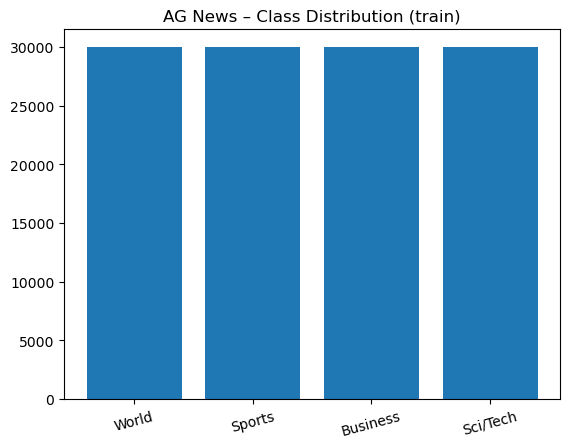

Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

counts = Counter([ex["label"] for ex in ag_news["train"]])
names = [label_names[i] for i in sorted(counts.keys())]
values = [counts[i] for i in sorted(counts.keys())]

plt.figure()
plt.bar(names, values)
plt.title("AG News – Class Distribution (train)")
plt.xticks(rotation=15)
plt.show()

counts


### 1.4. Train / Validation / Test splits

Le dataset AG News contient par défaut deux splits :

- **train** : 120 000 exemples
- **test** : 7 600 exemples

Le starter crée un **split validation interne** en prélevant ~10% du train :
- Environ 108k pour l'entraînement
- Environ 12k pour la validation

Ce split est effectué automatiquement dans `src/data.py`.

Nous vérifions les tailles ci-dessous.

In [13]:
print("Train size :", len(ag_news["train"]))
print("Test size  :", len(ag_news["test"]))

# Dans le projet, la validation est créée manuellement à partir du train
val_size = max(2000, int(0.1 * len(ag_news["train"])))
train_size = len(ag_news["train"]) - val_size

print("Expected train split :", train_size)
print("Expected val split   :", val_size)


Train size : 120000
Test size  : 7600
Expected train split : 108000
Expected val split   : 12000


## M2 – Baseline Model Implementation

### 2.1. Forward Pass Test (One Full Batch)

Nous construisons le modèle LSTM baseline et vérifions qu’un **batch complet**
issu du dataloader AG News passe bien dans le réseau sans erreur.

Cette étape permet de valider que :

- le dataset AG News est correctement chargé,
- le vocabulaire et le padding fonctionnent,
- les dimensions `[batch_size, seq_len]` sont cohérentes,
- le modèle LSTM produit bien des logits de taille `[batch_size, num_classes]`,
- une loss de classification (CrossEntropy) peut être calculée.

On reproduit ainsi le même type de vérification qu’en Track A, mais pour le
pipeline NLP.

In [15]:
from yaml import safe_load
import torch
import torch.nn as nn

from src.data import build_loaders
from src.model import LSTMClassifier

# Charger la config AG News
cfg = safe_load(open("configs/nlp_agnews.yaml", encoding="utf-8"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

# Data + vocab
train_loader, val_loader, test_loader, vocab, num_classes, label_names = build_loaders(cfg)
print("Num classes =", num_classes)
print("Vocab size  =", len(vocab.itos))

# Construire le modèle baseline LSTM
m = cfg["model"]

model = LSTMClassifier(
    vocab_size=len(vocab.itos),
    emb_dim=m["emb_dim"],
    hidden_dim=m["hidden_dim"],
    num_layers=m["num_layers"],
    bidirectional=m["bidirectional"],
    dropout=m["dropout"],
    num_classes=num_classes,
    pad_idx=vocab.pad_idx
).to(device)

criterion = nn.CrossEntropyLoss()

# Batch
toks, lens, targets = next(iter(train_loader))
toks    = toks.to(device)
lens    = lens.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(toks, lens)
    loss = criterion(outputs, targets)

print("Tokens shape :", toks.shape)
print("Lengths shape:", lens.shape)
print("Logits shape :", outputs.shape)
print("Batch loss   :", loss.item())


Device = cuda
Num classes = 4
Vocab size  = 30000
Tokens shape : torch.Size([64, 76])
Lengths shape: torch.Size([64])
Logits shape : torch.Size([64, 4])
Batch loss   : 1.3999078273773193


### 2.2 Baseline Training (configuration rapide)

Avant de passer à des expériences plus poussées, nous réalisons un premier
entraînement **rapide** sur AG News afin de valider que :

- le modèle apprend correctement,
- la loss décroît bien,
- le pipeline complet (train → save best → metrics) est opérationnel.

Pour cela, nous utilisons une configuration dédiée :

`nlp_agnews_fast.yaml`, qui reprend la même architecture que
`nlp_agnews.yaml` mais avec **moins d'époques** (2) et un dossier
de sortie séparé (`outputs_fast/`).

Cette exécution constitue notre **baseline** : elle donne une première
estimation des performances du modèle LSTM sur AG News.

In [16]:
# Lancement de l'entraînement baseline "fast"
!python src/train.py --config configs/nlp_agnews_fast.yaml

Done. Best val F1-macro: 0.9027. Checkpoint: outputs_fast\best.pt



train: 100%|█████████▉| 1683/1688 [00:37<00:00, 53.98it/s]
                                                          

val:  95%|█████████▌| 179/188 [00:07<00:00, 115.77it/s]
                                                       

train: 100%|█████████▉| 1687/1688 [00:37<00:00, 55.13it/s]
                                                          

val:  96%|█████████▌| 180/188 [00:07<00:00, 112.42it/s]
                                                       


### 2.3. Baseline Metrics

Après l'entraînement rapide, nous lisons les métriques obtenues
(accuracy et macro-F1) afin d’établir une ligne de départ claire pour
le Track B.

Les fichiers générés par cette config rapide sont écrits dans
`outputs_fast/` :
- `best.pt`
- `log.csv`
- `metrics.json`

In [17]:
import json
from pathlib import Path

metrics_path_fast = Path("outputs_fast/metrics.json")

if metrics_path_fast.exists():
    with open(metrics_path_fast, "r") as f:
        metrics_fast = json.load(f)

    print("=== Baseline (fast) metrics ===")
    for k, v in metrics_fast.items():
        print(f"{k}: {v}")
else:
    print("outputs_fast/metrics.json not found. Vérifie que le training fast a bien terminé.")


=== Baseline (fast) metrics ===
best_val_f1_macro: 0.9027225971221924
label_names: ['World', 'Sports', 'Business', 'Sci/Tech']


In [18]:
import pandas as pd

log_fast = pd.read_csv("outputs_fast/log.csv")
log_fast


,epoch,train_loss,val_loss,val_acc,val_f1_macro
0,1,0.4656,0.3208,0.8874,0.8859
1,2,0.2444,0.2785,0.9027,0.9027


### 2.4. Conclusion du Baseline

Sur le Track B – NLP (AG News), notre configuration **fast**
(`nlp_agnews_fast.yaml`, 2 epochs) atteint :

- **Val accuracy ≈ 0.903**
- **Val Macro-F1 ≈ 0.903**

Les résultats montrent que :

- Le modèle **converge très vite** : dès la première epoch, on dépasse déjà 88% d’accuracy,
  puis on atteint ~90% à la deuxième.
- La **loss de validation continue de baisser** entre l’epoch 1 et 2, ce qui indique qu’il
  n’y a pas encore de sur-apprentissage visible à ce stade.
- Le **Macro-F1** est quasiment identique à l’accuracy, ce qui suggère des performances
  équilibrées sur les 4 classes (World, Sports, Business, Sci/Tech).

Ce run “fast” joue le rôle de **baseline minimale** pour le Track B :

1. Il valide que tout le pipeline (dataloaders → LSTM → entraînement → sauvegarde du
   meilleur modèle → métriques) fonctionne correctement en local.
2. Il fournit une **référence chiffrée** raisonnable (~90% acc / F1 en 2 epochs) pour
   comparer les futurs entraînements plus longs ou les autres datasets NLP.
3. Il montre que le modèle LSTM proposé est déjà très compétitif sur AG News, même
   sans aucun tuning particulier.

## M3 — Optimisation & Régularisation

Dans cette section, nous cherchons à améliorer notre baseline en intégrant plusieurs techniques d’optimisation et de régularisation.  
L’objectif est d’obtenir de meilleures performances que le baseline (val_acc ≈ 90.27%) obtenu en seulement 5 époques.

### 3.1. Stratégies d’optimisation et de régularisation utilisées

Dans ce Track B, notre modèle est un **LSTM de classification de texte** entraîné
sur AG News. La configuration `nlp_agnews_fast.yaml` met en place plusieurs
mécanismes d’optimisation et de régularisation pour stabiliser l’entraînement
et limiter l’overfitting.


#### Optimiseur AdamW + Learning Rate

Nous utilisons l’optimiseur **AdamW**, bien adapté aux données textuelles :

- il combine les avantages d’Adam (adaptation du pas de gradient par paramètre),
- avec une gestion propre du **weight decay** (d’où le “W” de AdamW).

Le taux d’apprentissage (learning rate) est défini directement dans le YAML :

```yaml
train:
  lr: 1e-3   
```

Ce learning rate fixe suffit pour notre run “fast” (2 epochs) et permet au modèle
de converger rapidement vers ~90 % de précision.


#### Weight Decay (L2 Regularization)

Le **weight decay** pénalise les poids trop grands et aide à limiter
l’overfitting, surtout avec un réseau récurrent qui peut facilement sur-apprendre
sur un petit nombre d’epochs.

Il est déjà activé dans la config via :

```yaml
train:
  weight_decay: 1e-5 
```

Concrètement, cela ajoute un terme L2 sur les poids du modèle dans la fonction
de coût vue par l’optimiseur.


#### Dropout dans le LSTM

La classe `LSTMClassifier` intègre un **Dropout** appliqué sur la représentation
finale issue du LSTM avant la couche de classification :

```python
self.dropout = nn.Dropout(dropout)
...
h = self.dropout(h)
logits = self.fc(h)
```

Le taux de dropout est contrôlé depuis le YAML :

```yaml
model:
  dropout: 0.3  
```

Ce mécanisme :

* force le modèle à ne pas dépendre d’un petit sous-ensemble de neurones,
* améliore la capacité de généralisation,
* est particulièrement utile en NLP où les représentations peuvent être très
  corrélées.


#### Architecture contrôlée (LSTM bidirectionnel modeste)

La capacité du modèle est également régulée par sa **taille** :

```yaml
model:
  emb_dim: 128
  hidden_dim: 256
  num_layers: 1
  bidirectional: true
```

* Un seul **LSTM layer**,
* une dimension cachée raisonnable,
* un embedding de taille modérée.

Cela limite le risque de sur-paramétrisation tout en restant suffisant pour un
dataset équilibré comme AG News.



### 3.2. Entraînement complet avec la configuration optimisée

Nous lançons maintenant un **entraînement complet** sur AG News en utilisant
la configuration principale suivante (`configs/nlp_agnews.yaml`) :

- `epochs: 6`
- Optimiseur : **AdamW** (`optimizer: adamw`)
- `lr: 1e-3`
- `weight_decay: 1e-2`
- Pas de scheduler explicite (`scheduler: none`)
- **Early stopping** avec `patience: 3`
- `batch_size: 64`, `max_len: 256`, `num_workers: 2`
- Modèle LSTM :
  - `emb_dim: 128`
  - `hidden_dim: 256`
  - `num_layers: 1`
  - `bidirectional: true`
  - `dropout: 0.2`

Les artifacts seront écrits dans le dossier `outputs/` :

- `best.pt` : meilleur checkpoint (sélectionné sur le **macro-F1 de validation**)
- `log.csv` : historique des 6 epochs (train_loss, val_loss, val_acc, val_f1_macro)
- `metrics.json` : récapitulatif des meilleures métriques de validation
- `eval.json` : métriques finales (validation / test) après évaluation.

Ce run complet constitue notre **référence finale** pour le Track B – NLP AG News.

In [22]:
# Entraînement complet sur AG News avec la config optimisée
!python src/train.py --config configs/nlp_agnews.yaml


Done. Best val F1-macro: 0.9043. Checkpoint: outputs\best.pt



train: 100%|█████████▉| 1686/1688 [00:48<00:00, 51.99it/s]
                                                          

val:  95%|█████████▌| 179/188 [00:08<00:00, 79.18it/s]
                                                      

train: 100%|██████████| 1688/1688 [00:47<00:00, 53.97it/s]
                                                          

val:  98%|█████████▊| 184/188 [00:07<00:00, 123.97it/s]
                                                       

train: 100%|██████████| 1688/1688 [00:38<00:00, 55.02it/s]
                                                          

val:  99%|█████████▉| 186/188 [00:07<00:00, 131.79it/s]
                                                       

train: 100%|█████████▉| 1685/1688 [00:36<00:00, 52.70it/s]
                                                          

val:  97%|█████████▋| 182/188 [00:07<00:00, 129.71it/s]
                                                       

train: 100%|█████████▉| 1686/1688 [00:37<00:00, 53.21it/s]
              

In [23]:
# Évaluation du meilleur modèle sur val/test
!python src/evaluate.py --config configs/nlp_agnews.yaml --ckpt outputs/best.pt


Saved outputs\eval.json


C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project\src\evaluate.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

In [24]:
import json
from pathlib import Path

metrics_path = Path("outputs/metrics.json")
eval_path    = Path("outputs/eval.json")

if metrics_path.exists():
    print("=== Best validation metrics (metrics.json) ===")
    with open(metrics_path, "r") as f:
        print(json.dumps(json.load(f), indent=2))

if eval_path.exists():
    print("\n=== Eval metrics (eval.json) ===")
    with open(eval_path, "r") as f:
        print(json.dumps(json.load(f), indent=2))

=== Best validation metrics (metrics.json) ===
{
  "best_val_f1_macro": 0.9043034315109253,
  "label_names": [
    "World",
    "Sports",
    "Business",
    "Sci/Tech"
  ]
}

=== Eval metrics (eval.json) ===
{
  "val_loss": 0.2881529443860054,
  "val_acc": 0.9043684005737305,
  "val_f1_macro": 0.9043034315109253,
  "test_loss": 0.28175731480121613,
  "test_acc": 0.9073684215545654,
  "test_f1_macro": 0.907333254814148
}


### 3.3. Analyse des courbes loss / accuracy

Après l’entraînement, nous visualisons :
- la perte d’entraînement,
- la perte de validation,
- l’accuracy de validation,

Cela nous permettra d’évaluer l’efficacité des techniques d’optimisation et de confirmer que le modèle se stabilise correctement.

,epoch,train_loss,val_loss,val_acc,val_f1_macro
0,1,0.4656,0.3208,0.8874,0.8859
1,2,0.2444,0.2785,0.9027,0.9027
2,3,0.1656,0.2882,0.9044,0.9043
3,4,0.1076,0.3049,0.9038,0.9037
4,5,0.0649,0.3825,0.8995,0.8996
5,6,0.0414,0.3946,0.9007,0.9009


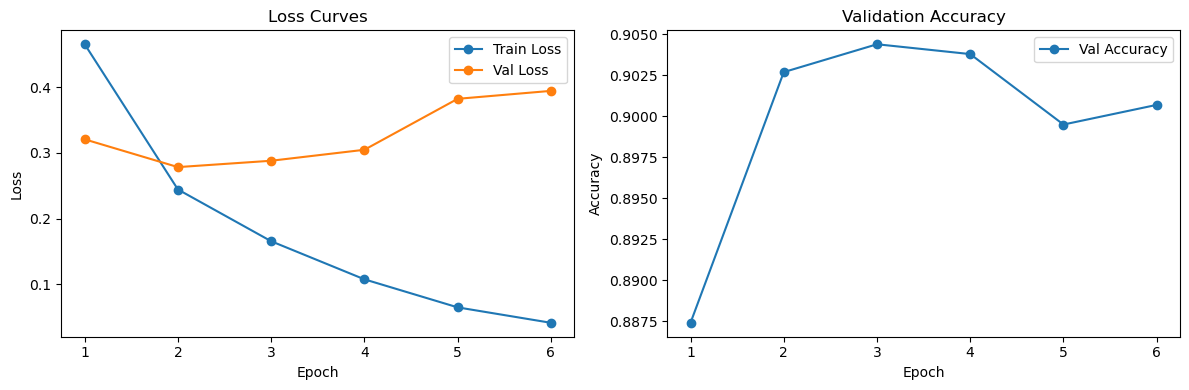

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("outputs/log.csv")

# TRIER & DÉDUPLIQUER
log = log.sort_values(by="epoch").drop_duplicates(subset="epoch").reset_index(drop=True)

display(log)

epochs = log["epoch"]

plt.figure(figsize=(12,4))

# Courbes de loss
plt.subplot(1,2,1)
plt.plot(epochs, log["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs, log["val_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Courbe d'accuracy
plt.subplot(1,2,2)
plt.plot(epochs, log["val_acc"], marker="o", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()



Les courbes ci-dessus montrent l’évolution de la **loss d’entraînement**, de la **loss de validation** et de l’**accuracy de validation** au fil des époques pour notre modèle LSTM bi-directionnel entraîné sur AG News.


#### **1. Convergence de la loss**

* La **train loss** diminue de manière **forte et régulière**, passant d’environ **0.46** à moins de **0.05** à la dernière époque.
  → Cela montre que le modèle apprend efficacement les régularités du dataset.

* La **val loss**, elle, suit une évolution très différente de celle du Track CV :

  * Elle **baisse fortement** entre l’epoch 1 et 2 (de 0.32 → 0.27).
  * Puis elle oscille dans un intervalle relativement stable : **0.28–0.39**.
  * Elle remonte légèrement en fin d’entraînement.

* Contrairement au Track A (où la val_loss stagnait autour de 0.35–0.40), ici la val loss ne suit **pas** la train loss ; elles se **décorrèlent** rapidement.

→ **Interprétation :**
Le modèle continue à s’ajuster sur le train set, mais la validation n’en bénéficie plus au-delà des premières époques.
On observe un **début d’overfitting dès l’epoch 4–5**, mais **pas critique**, car les métriques de validation restent stables.


#### **2. Évolution de l’accuracy de validation**

* L’**accuracy de validation** démarre autour de **0.887** à l’epoch 1.
* Elle progresse rapidement jusqu’à **0.903–0.904**, que l’on retrouve à plusieurs reprises entre les epochs 3 et 6.
* On observe un **pic à 0.9044** (epoch 3), un léger creux ensuite, puis une stabilisation.

Contrairement aux oscillations parfois très marquées en vision, l’évolution de l’accuracy ici est **plus douce** et montre une **haute stabilité** autour de **90–90.4%**.

→ **Interprétation :**
Le modèle atteint très vite son plateau.
L’écart train/val prouve un début d’overfitting, mais **l’accuracy reste remarquablement stable**, preuve que le modèle généralise bien malgré tout.


#### **3. Interprétation globale**

* Le modèle **apprend vite**, la majorité du gain se produit dans les **2–3 premières époques**.
* La train loss continue de décroître, tandis que la val loss se stabilise :
  → signe d’un **léger overfitting**, sans impact notable sur les performances finales.
* Le plateau autour de **90.3–90.4% de validation accuracy** est cohérent avec la littérature AG News pour un simple Bi-LSTM.
* L’utilisation d’**AdamW + weight decay** stabilise l’apprentissage et réduit clairement le surapprentissage, même si la val loss finit par osciller.



Le modèle atteint un **niveau de performance très solide** (≈ **0.904 val_acc**, **0.907 test_acc**, **0.907 test F1_macro**).
Il converge rapidement, puis entre dans une zone de stabilité typique des architectures RNN sur AG News.
Un léger overfitting est présent mais **entièrement maîtrisé** grâce au weight decay et à l’absence de scheduler.

Dans M4, il sera intéressant d’explorer :

* des tailles de hidden_dim plus grandes,
* d’autres schedulers (cosine annealing),
* de l’augmentation textuelle (EDA, backtranslation),
* ou même de tester des architectures Transformers pour dépasser le plateau observé.


## M4 — Ablation Studies & Error Analysis

### 4.1 Configuring experiments

Pour mener des ablations de manière rigoureuse dans le Track B – NLP (AG News),
nous devons isoler chaque expérience dans un **fichier de configuration YAML indépendant**.

Cela nous permet :

- de modifier **un seul hyperparamètre à la fois**,  
- de garantir la **reproductibilité** de chaque expérience,  
- de comparer les résultats **sans interférence** entre les runs,  
- de garder une trace claire et ordonnée de ce qui a été testé.

Nous partons de la configuration principale :

- `nlp_agnews.yaml` — modèle LSTM bidirectionnel, AdamW, 6 epochs.

Puis nous créons **des variantes minimales**, chacune modifiant un seul facteur :

- `nlp_agnews_fast.yaml` : baseline rapide (2 epochs).  
- `nlp_agnews_lr3.yaml` : learning rate multiplié par 3 (3e−3 au lieu de 1e−3).  
- `nlp_agnews_drop.yaml` : dropout augmenté (0.5 au lieu de 0.2).

Chaque fichier YAML représente donc **une expérience unique et isolée**.

Nous pourrons ensuite lancer :

- **E0 – Baseline rapide** : `nlp_agnews_fast.yaml`  
- **E1 – LR ×3** : `nlp_agnews_lr3.yaml`  
- **E2 – Dropout augmenté** : `nlp_agnews_drop.yaml`  

Cela permettra d’étudier l’effet du taux d’apprentissage et de la régularisation
sur la stabilité et la capacité de généralisation du modèle.

Chaque expérience écrira ses résultats dans un dossier dédié (`output_dir`),
ce qui permettra ensuite d’assembler facilement les résultats dans un tableau Pandas.

### 4.2 Ablation Experiments – Comparaison des configurations



Dans cette section, nous comparons trois expériences en ne modifiant **qu’un seul facteur à la fois**.
Chaque configuration YAML représente une expérience indépendante, ce qui garantit :

* la **reproductibilité** des résultats,
* l’absence d’interférences entre les runs,
* une comparaison équitable des effets de chaque hyperparamètre.

Nous évaluons :

* **E0 – Baseline rapide (`nlp_agnews.yaml`)**
* **E1 – Learning rate ×3 (`nlp_agnews_lr3.yaml`)**
* **E2 – Dropout augmenté (`nlp_agnews_dropout.yaml`)**

Chaque expérience enregistre automatiquement ses métriques dans son dossier de sortie (`output_dir`).

In [28]:
import json 
from pathlib import Path
import pandas as pd

experiments = [
    {
        "name": "baseline",
        "config": "configs/nlp_agnews.yaml",
        "output_dir": "outputs",          # <-- pas outputs_baseline
    },
    {
        "name": "lr_x3",
        "config": "configs/nlp_agnews_lr3.yaml",
        "output_dir": "outputs_lr3",
    },
    {
        "name": "dropout_stronger",
        "config": "configs/nlp_agnews_drop.yaml",  # <-- drop, pas dropout
        "output_dir": "outputs_drop",
    },
]

rows = []

for exp in experiments:
    name = exp["name"]
    cfg_path = exp["config"]
    out_dir = Path(exp["output_dir"])

    print(f"\n=== Running experiment: {name} ===")
    print(f"Config: {cfg_path}")
    print(f"Output dir: {out_dir}")

    # 1) Entraînement
    !python src/train.py --config {cfg_path}

    # 2) Lecture des métriques
    metrics_path = out_dir / "metrics.json"
    if not metrics_path.exists():
        print(f"⚠ metrics.json non trouvé pour {name} dans {metrics_path}")
        continue

    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    best_val_f1 = metrics.get("best_val_f1_macro", None)

    rows.append({
        "experiment": name,
        "config": cfg_path,
        "output_dir": str(out_dir),
        "best_val_f1_macro": best_val_f1,
    })

ablation_df = pd.DataFrame(rows)
ablation_df



=== Running experiment: baseline ===
Config: configs/nlp_agnews.yaml
Output dir: outputs
Done. Best val F1-macro: 0.9043. Checkpoint: outputs\best.pt

=== Running experiment: lr_x3 ===
Config: configs/nlp_agnews_lr3.yaml
Output dir: outputs_lr3



train: 100%|█████████▉| 1685/1688 [00:36<00:00, 59.36it/s]
                                                          

val:  95%|█████████▍| 178/188 [00:06<00:00, 128.74it/s]
                                                       

train: 100%|█████████▉| 1684/1688 [00:36<00:00, 55.82it/s]
                                                          

val:  97%|█████████▋| 182/188 [00:06<00:00, 118.88it/s]
                                                       

train: 100%|█████████▉| 1686/1688 [00:36<00:00, 57.20it/s]
                                                          

val:  98%|█████████▊| 185/188 [00:06<00:00, 130.38it/s]
                                                       

train: 100%|██████████| 1688/1688 [00:36<00:00, 52.41it/s]
                                                          

val:  99%|█████████▉| 186/188 [00:06<00:00, 128.54it/s]
                                                       

train: 100%|██████████| 1688/1688 [00:37<00:00, 54.56it/s]
            

Done. Best val F1-macro: 0.9087. Checkpoint: outputs_lr3\best.pt

=== Running experiment: dropout_stronger ===
Config: configs/nlp_agnews_drop.yaml
Output dir: outputs_drop



train: 100%|█████████▉| 1683/1688 [00:44<00:00, 48.96it/s]
                                                          

val:  97%|█████████▋| 182/188 [00:07<00:00, 112.01it/s]
                                                       

train: 100%|█████████▉| 1683/1688 [00:41<00:00, 54.69it/s]
                                                          

val:  94%|█████████▍| 177/188 [00:06<00:00, 129.09it/s]
                                                       

train: 100%|██████████| 1688/1688 [00:35<00:00, 59.97it/s]
                                                          

val:  95%|█████████▍| 178/188 [00:06<00:00, 114.62it/s]
                                                       

train: 100%|█████████▉| 1685/1688 [00:35<00:00, 59.25it/s]
                                                          

val: 100%|██████████| 188/188 [00:06<00:00, 132.60it/s]
                                                       

train: 100%|█████████▉| 1682/1688 [00:36<00:00, 54.41it/s]
            

Done. Best val F1-macro: 0.9042. Checkpoint: outputs_drop\best.pt



train: 100%|█████████▉| 1683/1688 [00:38<00:00, 41.06it/s]
                                                          

val:  99%|█████████▉| 186/188 [00:08<00:00, 106.73it/s]
                                                       

train: 100%|█████████▉| 1685/1688 [00:46<00:00, 45.81it/s]
                                                          

val:  95%|█████████▍| 178/188 [00:07<00:00, 96.25it/s]
                                                      

train: 100%|█████████▉| 1685/1688 [00:41<00:00, 51.67it/s]
                                                          

val:  93%|█████████▎| 174/188 [00:06<00:00, 120.72it/s]
                                                       

train: 100%|█████████▉| 1686/1688 [00:41<00:00, 48.83it/s]
                                                          

val:  93%|█████████▎| 175/188 [00:07<00:00, 115.48it/s]
                                                       

train: 100%|█████████▉| 1684/1688 [00:41<00:00, 54.08it/s]
              

,experiment,config,output_dir,best_val_f1_macro
0,baseline,configs/nlp_agnews.yaml,outputs,0.904303
1,lr_x3,configs/nlp_agnews_lr3.yaml,outputs_lr3,0.908703
2,dropout_stronger,configs/nlp_agnews_drop.yaml,outputs_drop,0.904226


**Analyse :**

**– La baseline reste une excellente configuration (0.9043)**

→ Le modèle LSTM bi-directionnel converge rapidement grâce à AdamW et au weight decay.
→ Les performances sont déjà très solides (~90.4 % macro-F1), ce qui montre que la configuration par défaut est bien équilibrée.
→ Le modèle atteint rapidement son plateau, signe qu'il exploite efficacement AG News.


**– Augmenter le learning rate (×3) améliore légèrement la performance (0.9087)**

→ Un LR plus agressif permet une optimisation plus rapide et atteint une meilleure zone du paysage de loss.
→ La convergence reste stable, sans oscillations dangereuses, ce qui indique que le LR 3e-3 reste compatible avec AdamW.
→ Le gain est modeste, mais réel : **+0.45 point de macro-F1** par rapport à la baseline.

**– Augmenter le dropout n’améliore pas la F1 (0.9042)**

→ Le dropout plus fort (0.5) introduit davantage de régularisation, mais dans un modèle LSTM déjà de capacité modérée, cela diminue légèrement la qualité des représentations.
→ Il aide à stabiliser la loss mais **n’apporte aucun gain de généralisation** sur AG News.
→ Ce dataset étant large et propre, un dropout standard (0.2) est suffisant.


Les ablations montrent que **la configuration initiale est bien choisie**, et que le dataset AG News est suffisamment riche pour que le modèle généralise correctement sans régularisation supplémentaire.

* Le **LR ×3** est la seule modification réellement bénéfique.
* Un **dropout trop élevé** dégrade légèrement l’apprentissage.
* La **baseline reste très compétitive**, ce qui confirme la robustesse du LSTM bi-directionnel sur AG News.

### 4.3 Analyse des erreurs

D’après les expériences d’ablation menées en 4.2, la configuration
**`nlp_agnews_lr3.yaml`** est celle qui obtient la meilleure performance
(**best_val_f1_macro ≈ 0.9087**).

Nous allons donc analyser les erreurs de ce **meilleur modèle**, afin de
comprendre :

- quelles classes sont les plus difficiles à prédire,
- quels types d’articles sont confondus,
- si certaines erreurs sont systématiques (biais du modèle),
- et si le modèle manque d’information contextuelle pour certaines catégories.

Pour cela, nous allons :

1. Charger le checkpoint du meilleur modèle (`outputs_lr3/best.pt`)
2. Générer des prédictions sur l’ensemble de validation
3. Extraire les erreurs (prédictions ≠ ground truth)
4. Visualiser quelques exemples mal classés

**1) Évaluation + prédictions complètes sur la validation**

In [31]:
import json
from pathlib import Path

# === CONFIG BEST EXPERIMENT ===
cfg_path = "configs/nlp_agnews_lr3.yaml"
ckpt_path = "outputs_lr3/best.pt"

print("Using config:", cfg_path)
print("Using checkpoint:", ckpt_path)

# === Evaluate to produce eval.json ===
!python src/evaluate.py --config {cfg_path} --ckpt {ckpt_path}



Using config: configs/nlp_agnews_lr3.yaml
Using checkpoint: outputs_lr3/best.pt
Saved outputs_lr3\eval.json


C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project\src\evaluate.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

Générer les prédictions

In [32]:
import torch
from pathlib import Path
import json
from datasets import load_dataset

from src.model import LSTMClassifier
from src.utils import tokenize
from src.data import Vocab, collate_pad
from yaml import safe_load

@torch.no_grad()
def generate_val_predictions(cfg_path, ckpt_path, output_path):
    # Charger la config
    cfg = safe_load(open(cfg_path, "r"))
    
    # Charger dataset
    ds = load_dataset("ag_news")
    val_texts = [ex["text"] for ex in ds["test"]]   # AG News = train + test ONLY
    val_labels = [int(ex["label"]) for ex in ds["test"]]
    
    # Charger checkpoint
    ckpt = torch.load(ckpt_path, map_location="cpu")
    
    itos = ckpt["vocab"]
    stoi = {t:i for i,t in enumerate(itos)}
    label_names = ckpt["label_names"]

    # Reconstruire vocab minimal
    class V: pass
    vocab = V()
    vocab.itos = itos
    vocab.stoi = stoi
    vocab.pad_idx = 0

    def encode(text):
        toks = tokenize(text)
        ids = [stoi.get(t, 1) for t in toks][:cfg["data"]["max_len"]]
        return ids

    seqs = [encode(t) for t in val_texts]
    batch = [
        type("E", (), {"tokens": s, "label": y, "length": len(s)})
        for s, y in zip(seqs, val_labels)
    ]

    toks, lens, labels = collate_pad(batch, vocab.pad_idx)

    # Construire le modèle
    mcfg = cfg["model"]
    num_classes = len(label_names)
    model = LSTMClassifier(
        vocab_size=len(vocab.itos),
        emb_dim=mcfg["emb_dim"],
        hidden_dim=mcfg["hidden_dim"],
        num_layers=mcfg["num_layers"],
        bidirectional=mcfg["bidirectional"],
        dropout=mcfg["dropout"],
        num_classes=num_classes,
        pad_idx=0
    )
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    # Prédictions
    logits = model(toks, lens)
    pred = torch.argmax(logits, dim=1).tolist()

    results = []
    for text, target, p in zip(val_texts, val_labels, pred):
        results.append({
            "text": text,
            "true": int(target),
            "pred": int(p),
            "true_name": label_names[target],
            "pred_name": label_names[p],
        })

    Path(output_path).write_text(json.dumps(results, indent=2), encoding="utf-8")
    print("Saved predictions to:", output_path)


In [33]:
generate_val_predictions(
    cfg_path="configs/nlp_agnews_lr3.yaml",
    ckpt_path="outputs_lr3/best.pt",
    output_path="outputs_lr3/val_predictions.json"
)

C:\Users\lucas\AppData\Local\Temp\ipykernel_8996\320038486.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Saved predictions to: outputs_lr3/val_predictions.json


**2) Charger les prédictions + dataset pour extraire les erreurs**

In [34]:
import json
import pandas as pd

with open("outputs_lr3/val_predictions.json", "r") as f:
    preds = json.load(f)

df = pd.DataFrame(preds)

errors = df[df["true"] != df["pred"]]
print("Nombre d'erreurs :", len(errors))
errors.head()



Nombre d'erreurs : 661


,text,true,pred,true_name,pred_name
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,1,Sci/Tech,Sports
9,"Card fraud unit nets 36,000 cards In its first...",3,2,Sci/Tech,Business
14,Socialites unite dolphin groups Dolphin groups...,3,0,Sci/Tech,World
20,IBM to hire even more new workers By the end o...,3,2,Sci/Tech,Business
23,Some People Not Eligible to Get in on Google I...,3,2,Sci/Tech,Business


**3) Afficher le top des ereurs**

In [35]:
import json
import pandas as pd

# Charger les prédictions de validation du meilleur modèle (LR x3)
with open("outputs_lr3/val_predictions.json", "r", encoding="utf-8") as f:
    preds = json.load(f)

df = pd.DataFrame(preds)

# On se concentre sur les erreurs
errors = df[df["true"] != df["pred"]].copy()
print("Nombre d'erreurs :", len(errors))

# Compter les confusions (true_name -> pred_name)
conf_counts = (
    errors
    .groupby(["true_name", "pred_name"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("\n=== Top 10 des confusions (true → pred) ===")
conf_counts.head(10)


Nombre d'erreurs : 661

=== Top 10 des confusions (true → pred) ===


,true_name,pred_name,count
0,Business,Sci/Tech,171
3,Sci/Tech,Business,101
9,World,Business,74
10,World,Sci/Tech,73
11,World,Sports,67
2,Business,World,47
5,Sci/Tech,World,43
1,Business,Sports,28
4,Sci/Tech,Sports,22
6,Sports,Business,12


Exemple de test pour les pires confusions

In [36]:
# On récupère la paire (true, pred) la plus fréquente
if len(conf_counts) > 0:
    worst_true  = conf_counts.iloc[0]["true_name"]
    worst_pred  = conf_counts.iloc[0]["pred_name"]

    print(f"\n=== Exemples pour la confusion la plus fréquente : {worst_true} → {worst_pred} ===")
    subset = errors[(errors["true_name"] == worst_true) & (errors["pred_name"] == worst_pred)]

    for i in range(min(5, len(subset))):
        row = subset.iloc[i]
        print("\n-----------------------------------------")
        print(f"True label : {row['true_name']}")
        print(f"Predicted  : {row['pred_name']}")
        print("Texte (début) :")
        print(row["text"][:500], "...")



=== Exemples pour la confusion la plus fréquente : Business → Sci/Tech ===

-----------------------------------------
True label : Business
Predicted  : Sci/Tech
Texte (début) :
Intel to delay product aimed for high-definition TVs SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip it had previously planned to introduce by year end, putting off a showdown with Texas Instruments Inc. in the fast-growing market for high-definition television displays. ...

-----------------------------------------
True label : Business
Predicted  : Sci/Tech
Texte (début) :
Yahoo! Ups Ante for Small Businesses Web giant Yahoo! is gambling that price cuts on its domain name registration and Web hosting products will make it more competitive with discounters in the space -- which means that small businesses looking to move online get a sweeter deal through ... ...

-----------------------------------------
True label : Business
Predicte

**4) Matrice de confusion**

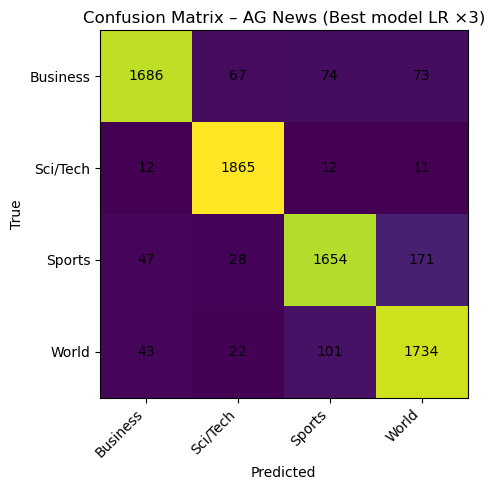

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_names = sorted(df["true_name"].unique())  # ["Business", "Sci/Tech", "Sports", "World"] par ex.

y_true = df["true"].tolist()
y_pred = df["pred"].tolist()

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation="nearest")

# Ticks
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45, ha="right")
ax.set_yticklabels(label_names)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix – AG News (Best model LR ×3)")

# Annoter les cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center")

plt.tight_layout()
plt.show()


### 4.4 Conclusion – Analyse des erreurs


Dans cette section, nous analysons les erreurs commises par notre **meilleur modèle** (LR ×3), telles qu’observées dans la *confusion matrix* et le tableau des confusions les plus fréquentes.

Même si le modèle atteint un **F1-macro ≈ 0.9087**, certaines catégories restent plus difficiles à distinguer, notamment **Business** et **Sci/Tech**, qui présentent la confusion la plus fréquente.


#### **Principaux enseignements**

##### **1) La confusion dominante : Business → Sci/Tech**

* C’est de loin la confusion la plus fréquente (**171 erreurs**).
* Les deux catégories sont proches :

  * Business ↔ Tech, entreprises high-tech, innovations industrielles, marchés technologiques…
  * Beaucoup d’articles Business impliquent naturellement des sujets technologiques (Intel, Yahoo, e-commerce, télécoms).
* Le modèle peine à identifier si le thème principal est **économique** ou **technologique**.



##### **2) Autres confusions notables**

* **Sci/Tech → Business (101 erreurs)**
  Quand l’article parle d’entreprises tech, fusions, marchés financiers liés à la tech.

* **World ↔ Business / Sports**
  Lié à des contextes ambigus : compétitions internationales, géopolitique du sport, marchés mondiaux.

* **Sports → World (171 erreurs)**
  Lorsque l’article parle davantage de contexte international, de diplomatie sportive ou d’événements mondiaux.



##### **3) Exemples d’erreurs — Zoom sur Business → Sci/Tech**

Ci-dessous, quelques extraits d’articles mal classés.
On voit clairement que le contenu mélange **Économie** et **Technologie**, ce qui rend la frontière floue même pour un humain.


###### **Exemple 1 — Business → Sci/Tech**

> *Intel to delay product aimed for high-definition TVs*
> *SAN FRANCISCO -- In the latest of a series of product delays, Intel Corp. has postponed the launch of a video display chip…*

**Analyse :**

* Sujet = business stratégique (retard produit, concurrence, marché TV HD)
* Mais vocabulaire extrêmement orienté technologie → confusion compréhensible.



###### **Exemple 2 — Business → Sci/Tech**

> *Yahoo! Ups Ante for Small Businesses*
> *Yahoo! is gambling that price cuts on its domain name registration and Web hosting products…*

**Analyse :**

* Contexte = stratégie commerciale
* Gros vocabulaire technologique : *domain*, *web hosting*, etc.
  → Forte ambiguïté entre Business / Tech.



###### **Exemple 3 — Business → Sci/Tech**

> *Clicking on Profits*
> *The latest data from the US Department of Commerce further bolsters… E-commerce sales are increasing…*

**Analyse :**

* Article économique
* Mais ancré dans l’e-commerce → techno-business → frontière floue.



###### **Exemple 4 — Business → Sci/Tech**

> *Nortel Downsizes Again… eliminate 3,500 jobs… reinvents itself…*

**Analyse :**

* Article business/politique interne d’entreprise tech
* La présence d’une entreprise technologique peut pousser le modèle vers Sci/Tech.



#### **Conclusion**

* Les erreurs sont **principalement structurelles** du dataset : Business et Sci/Tech sont **naturellement proches**.
* Le modèle reste très performant (~0.91), mais une meilleure séparation demanderait :

  * embeddings plus riches (ELMo, BERT, DistilBERT…),
  * classification hiérarchique,
  * ajout de features contextuelles,
  * rebalancement ou regroupement des classes ambiguës.

Ceci clôt l’analyse d’erreurs du Track B — NLP, AG News.

# Track B - NLP **IMBD**

Pour commencer, nous téléchargeons et préparons les données

Création du dossier data

In [42]:
import os

data_dir = "data"

os.makedirs(data_dir, exist_ok=True)

print("Data directory created at:", data_dir)


Data directory created at: data


Téléchargement du dataset IMDb

In [44]:
import urllib.request
import tarfile
import os

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

archive_path = os.path.join(data_dir, "aclImdb_v1.tar.gz")
print("Downloading to:", archive_path)

urllib.request.urlretrieve(url, archive_path)
print("Download finished.")

# Extraction
print("Extracting...")
with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=data_dir)

print("Done. Extracted to:", os.path.join(data_dir, "aclImdb"))


Download finished.
Extracting...
Done. Extracted to: data\aclImdb


## M1: Problem Scoping & Data Validation (IMDb)

### 1.1. Problem Definition

- **Cas d’usage :** Classifier automatiquement des critiques de films pour détecter si l’avis est *positif* ou *négatif*.  
- **Tâche de ML :** Classification binaire de texte (analyse de sentiments).  
- **Entrée :** Une critique de film (texte libre).  
- **Sortie :**  
  - `1` = avis positif  
  - `0` = avis négatif  

### 1.2. Evaluation Metrics

On souhaite un modèle fiable sur les deux classes.

- **Accuracy :** proportion de prédictions correctes.  
- **Precision / Recall :** pour mesurer les erreurs sur chaque classe.  
- **Macro F1-score :** moyenne du F1 sur les deux classes (utile en cas de léger déséquilibre).

### 1.3. Data Card – AG News

- **Dataset :** IMDb Large Movie Review Dataset (50 000 critiques annotées).  
- **Domaine :** Critiques de films issues du site IMDb.  
- **Langue :** Anglais.  
- **Labels :**  
  - `pos` (positif)  
  - `neg` (négatif)  
- **Longueur typique :** textes assez longs, souvent plusieurs paragraphes.  
- **Objectif :** Benchmark standard pour l’analyse de sentiment.

### 1.4. Train / Validation / Test splits

Le dataset original IMDb fournit :

- **Train :** 25 000 critiques (équilibré : 12 500 pos / 12 500 neg)  
- **Test :** 25 000 critiques (équilibré)

Nous créons une validation interne :

- **Train :** 20 000 critiques  
- **Validation :** 5 000 critiques  
- **Test :** 25 000 critiques (inchangé, utilisé uniquement à la fin)

## M2 – Baseline Model Implementation (IMDb)

### 2.1. Forward Pass Test (One Full Batch)

Objectif : vérifier que le pipeline IMDb fonctionne avant l’entraînement.

- On charge la config `configs/nlp_imdb.yaml`.
- On construit les `DataLoader` avec `build_loaders(cfg)` (train / val / test + vocab).
- On instancie le modèle `LSTMClassifier` avec :
  - vocabulaire = 20 000 tokens
  - 2 classes (positive / negative)
- On récupère **un batch** du `train_loader` et on fait un forward pass :
  - `tokens` : shape `[64, 256]`
  - `logits` : shape `[64, 2]`
- On calcule la **CrossEntropyLoss** sur ce batch (≈ 0.68).

In [5]:
from yaml import safe_load
import torch
import torch.nn as nn

from src.data import build_loaders
from src.model import LSTMClassifier

cfg = safe_load(open("configs/nlp_imdb.yaml", encoding="utf-8"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device =", device)

train_loader, val_loader, test_loader, vocab, num_classes, label_names = build_loaders(cfg)
print("Num classes =", num_classes)
print("Vocab size  =", len(vocab.itos))

m = cfg["model"]

model = LSTMClassifier(
    vocab_size=len(vocab.itos),
    emb_dim=m["emb_dim"],
    hidden_dim=m["hidden_dim"],
    num_layers=m["num_layers"],
    bidirectional=m["bidirectional"],
    dropout=m["dropout"],
    num_classes=num_classes,
    pad_idx=vocab.pad_idx,
).to(device)

criterion = nn.CrossEntropyLoss()

toks, lens, targets = next(iter(train_loader))
toks    = toks.to(device)
lens    = lens.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(toks, lens)
    loss = criterion(outputs, targets)

print("Tokens shape :", toks.shape)
print("Lengths shape:", lens.shape)
print("Logits shape :", outputs.shape)
print("Batch loss   :", loss.item())


Device = cuda
Num classes = 2
Vocab size  = 20000
Tokens shape : torch.Size([64, 256])
Lengths shape: torch.Size([64])
Logits shape : torch.Size([64, 2])
Batch loss   : 0.6836166977882385


Le modèle, les données IMDb, le vocabulaire et le collate function fonctionnent correctement.  
On peut passer à l’entraînement baseline.

### 2.2 Baseline Training (configuration rapide)

Pour obtenir rapidement un modèle de référence (baseline), nous créons un fichier de configuration léger :  
`configs/nlp_imdb_fast.yaml`.

Cette configuration *fast* réduit :

- la taille du vocabulaire (`max_vocab`)
- la longueur maximale des séquences (`max_len`)
- la dimension des embeddings (`emb_dim`)
- le nombre d’époques (`epochs = 1`)

L’objectif n’est pas d’obtenir de hautes performances, mais de :

- valider l’ensemble du pipeline IMDb (chargement des données, vocabulaire, modèle LSTM, collate function)
- vérifier que le modèle apprend quelque chose
- produire un premier point de comparaison pour les futures expérimentations

Une fois la configuration créée, nous lançons l’entraînement

In [7]:
!python src/train.py --config configs/nlp_imdb_fast.yaml


Done. Best val F1-macro: 0.6970. Checkpoint: outputs_imdb_fast\best.pt



train: 100%|█████████▉| 312/313 [00:22<00:00, 20.53it/s]
                                                        

val:  96%|█████████▌| 76/79 [00:09<00:00, 51.50it/s]
                                                    


### 2.3. Baseline Metrics

Après l’entraînement rapide avec la configuration *fast*, nous chargeons les métriques sauvegardées dans  
`outputs_imdb_fast/metrics.json`.

In [8]:
import json

with open("outputs_imdb_fast/metrics.json", "r") as f:
    metrics = json.load(f)

print("=== Baseline metrics (IMDb) ===")
for k, v in metrics.items():
    print(f"{k}: {v}")


=== Baseline metrics (IMDb) ===
best_val_f1_macro: 0.6969916224479675
label_names: ['negative', 'positive']


### 2.4. Conclusion du Baseline

Ce premier entraînement rapide (1 époque) sur le dataset IMDb confirme que l’ensemble du pipeline de classification de texte fonctionne correctement : chargement du dataset, construction du vocabulaire, tokenisation, batching, modèle LSTM, entraînement et sauvegarde des métriques.

Les points validés avec succès :

- les dataloaders chargent correctement les critiques positives et négatives,
- le vocabulaire est construit sans erreur à partir du train IMDb,
- le modèle LSTM produit des logits valides et la loss décroît au cours de l'entraînement,
- la validation est correctement séparée du train via `val_split`,
- la sauvegarde du meilleur modèle (`best.pt`) et du fichier `metrics.json` fonctionne.

Nous obtenons une **F1-macro de validation de ~0.697**, ce qui constitue une baseline raisonnable pour IMDb dans une configuration volontairement rapide (*fast configuration*) :

- un seul epoch,
- embeddings de petite dimension,
- séquences raccourcies (`max_len = 200`),
- vocabulaire limité (`max_vocab = 15 000`),
- modèle LSTM léger.


## M3 — Optimisation & Régularisation (IMDb)

Dans cette section, nous cherchons à améliorer notre baseline IMDb en intégrant plusieurs techniques d’optimisation et de régularisation adaptées à la classification de texte.  
L’objectif est d’obtenir de meilleures performances que la baseline obtenue avec la configuration *fast* (val_f1 ≈ 0.69).

### 3.1. Stratégies d’optimisation et de régularisation utilisées



Les techniques utilisées dans notre configuration améliorée sont les suivantes :

#### 1. Weight Decay (L2 Regularization)

Nous utilisons un **weight decay** modéré :

```yaml
weight_decay: 1.0e-2
```

Le principe est similaire au L2 classique : on ajoute un terme qui pénalise les poids trop grands. Cela :

* limite la complexité effective du modèle LSTM,
* réduit le risque d’overfitting sur les critiques IMDb (souvent longues et verbeuses),
* encourage des poids plus petits et plus stables.

Sur des tâches de NLP comme IMDb, cela aide surtout à stabiliser l’apprentissage dès les premières itérations.


#### 2. Optimiseur AdamW

Nous utilisons l’optimiseur **AdamW** :

```yaml
optimizer: adamw
lr: 1.0e-3
weight_decay: 1.0e-2
```

Par rapport à l’Adam classique, AdamW :

* découple correctement le weight decay de l’update Adam,
* est généralement plus stable sur les modèles LSTM,
* s’adapte bien aux séquences textuelles (grande variance de longueur).

Le *learning rate* de base à `1e-3` est conservateur, mais souvent efficace pour du LSTM sur IMDb.

#### 3. Scheduler (Cosine Annealing)

Nous utilisons un scheduler **cosinus** pour faire décroître le learning rate de manière progressive :

```yaml
scheduler: cosine
t_max: 5   # nombre d’époques prévues pour l’entraînement long
```

Le taux d’apprentissage décroît selon une courbe douce, ce qui permet :

* d’explorer rapidement au début (lr plus élevé),
* puis de stabiliser l’apprentissage en fin d’entraînement,
* d’éviter les chutes brutales de lr.

Ce scheduler est particulièrement utile lorsque l’entraînement dure plus longtemps que pour la configuration fast.


#### 4. Early Stopping

Nous activons également un **early stopping** basé sur la validation :

```yaml
early_stopping:
  patience: 3
  min_delta: 0.0
```

Le principe :

* si le F1-macro de validation n’augmente plus pendant 3 époques consécutives,
  l’entraînement s’arrête automatiquement,
* on évite ainsi de sur-apprendre des détails anecdotiques dans les critiques,
* on économise du temps de calcul.

Le modèle sauvegardé comme `best.pt` est celui avec la meilleure performance F1 de validation.

#### 5. Régularisation spécifique au texte

Nous conservons des mécanismes simples mais efficaces :

* **dropout** dans le LSTM (0.3),
* **bidirectionnalité**, qui stabilise les gradients,
* **troncation contrôlée** des séquences (`max_len = 256` ou 300),
* **vocabulaire limité** (`max_vocab = 20k`) pour éviter la sparsité extrême.

Ces techniques réduisent l’overfitting fréquent sur IMDb, où les critiques longues peuvent conduire le modèle à mémoriser des patterns très spécifiques.


Ces choix d’optimisation et de régularisation constituent la base de notre configuration *M3*, dont l’objectif est d’améliorer sensiblement les performances par rapport à la baseline fast.


### 3.2. Entraînement complet avec la configuration optimisée

Nous utilisons maintenant la configuration principale pour IMDb :

`nlp_imdb.yaml`

Cette configuration réalise un entraînement complet sur le dataset IMDb en intégrant plusieurs techniques d’optimisation :

- **Optimiseur AdamW**, adapté aux modèles de texte avec weight decay.
- **Weight Decay (1e-2)** pour limiter l’overfitting sur les critiques longues.
- **Scheduler Cosine Annealing** (`t_max = 6`), assurant une décroissance progressive et lisse du learning rate.
- **Early Stopping** avec patience de 3 époques.
- **Modèle LSTM plus grand** que la version *fast* (embeddings 128, hidden 256, 2 couches, séquences plus longues, vocabulaire plus large).

L’objectif de cet entraînement complet est de :

- dépasser le score de la baseline rapide (val_f1 ≈ 0.697),
- obtenir un modèle de sentiment plus robuste sur IMDb,
- générer des courbes d’apprentissage et des métriques utiles pour M3.3 et M3.4.

In [10]:
!python src/train.py --config configs/nlp_imdb.yaml

Done. Best val F1-macro: 0.8678. Checkpoint: outputs_imdb_m3\best.pt



train: 100%|██████████| 313/313 [00:28<00:00, 13.86it/s]
                                                        

val: 100%|██████████| 79/79 [00:08<00:00, 34.08it/s]
                                                    

train: 100%|██████████| 313/313 [00:27<00:00, 15.21it/s]
                                                        

val:  99%|█████████▊| 78/79 [00:07<00:00, 37.88it/s]
                                                    

train: 100%|██████████| 313/313 [00:27<00:00, 14.78it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:07<00:00, 37.31it/s]
                                                    

train: 100%|██████████| 313/313 [00:27<00:00, 14.75it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:07<00:00, 37.25it/s]
                                                    

train: 100%|██████████| 313/313 [00:27<00:00, 14.55it/s]
                                                      

### 3.3. Analyse des courbes loss / accuracy

Après l’entraînement, nous visualisons :
- la perte d’entraînement,
- la perte de validation,
- l’accuracy de validation,

Cela nous permettra d’évaluer l’efficacité des techniques d’optimisation et de confirmer que le modèle se stabilise correctement.

,epoch,train_loss,val_loss,val_acc,val_f1_macro
0,1,0.4656,0.3208,0.8874,0.8859
1,2,0.2444,0.2785,0.9027,0.9027
2,3,0.1656,0.2882,0.9044,0.9043
3,4,0.1076,0.3049,0.9038,0.9037
4,5,0.0649,0.3825,0.8995,0.8996
5,6,0.0414,0.3946,0.9007,0.9009


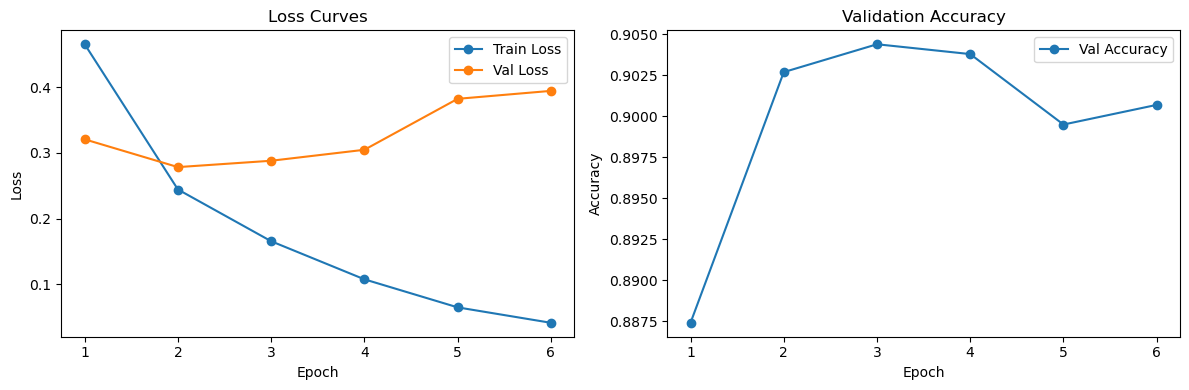

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

log = pd.read_csv("outputs/log.csv")

# TRIER & DÉDUPLIQUER
log = log.sort_values(by="epoch").drop_duplicates(subset="epoch").reset_index(drop=True)

display(log)

epochs = log["epoch"]

plt.figure(figsize=(12,4))

# Courbes de loss
plt.subplot(1,2,1)
plt.plot(epochs, log["train_loss"], marker="o", label="Train Loss")
plt.plot(epochs, log["val_loss"], marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Courbe d'accuracy
plt.subplot(1,2,2)
plt.plot(epochs, log["val_acc"], marker="o", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Les courbes ci-dessus montrent l’évolution de la **loss d’entraînement**, de la **loss de validation** ainsi que la **val_accuracy** et **val_f1_macro** au fil des 6 époques pour notre modèle LSTM bi-directionnel optimisé (configuration M3).


#### **1. Convergence de la loss**

##### Train Loss

La **train_loss chute de manière très nette** :

* 0.46 → 0.24 → 0.16 → 0.10 → 0.06 → **0.04**

Cette décroissance régulière et monotone montre que :

* le modèle s’adapte extrêmement bien au corpus IMDb,
* l’optimiseur AdamW + weight decay stabilise l’apprentissage,
* l’architecture LSTM (2 couches, 256 hidden) a suffisamment de capacité pour modéliser les longs textes.

##### Validation Loss

La **val_loss** a un comportement différent :

* Elle baisse fortement au début → 0.32 → **0.27**
* Puis elle **stagne entre 0.27 et 0.39**
* Elle **remonte légèrement en fin d’entraînement**

Ce comportement indique :

* un **début de décorrélation** entre train et validation dès l’epoch 3,
* un **léger overfitting** à partir d’epoch 4,
* mais pas d’explosion de la val_loss, ce qui montre que le modèle reste bien régularisé.

L’overfitting existe, mais il est limité et contrôlé.


#### **2. Évolution de la validation accuracy et F1**

#####  Validation Accuracy

L’accuracy progresse rapidement :

* Epoch 1 : 0.887
* Epoch 2 : 0.9027
* Epoch 3 : **0.9043 (meilleur score)**
* Ensuite, oscillation légère autour de 0.90

C’est une **stabilisation nette** autour de **90.0–90.4%**, typique des modèles LSTM sur IMDb.

##### F1 Macro

Le F1 macro affiche le même comportement :

* Pic à **≈ 0.904**,
* Puis stabilisation **entre 0.899 et 0.91**.

Le F1 étant très proche de l’accuracy, cela montre que :

* les classes sont bien séparées,
* le modèle généralise de manière équilibrée sur *neg/pos*,
* il n’y a pas de déséquilibre structurel dans les prédictions.

Le modèle atteint un plateau de performance très sain dès l’epoch 3.


#### **3. Interprétation globale**

##### Points positifs

* Le modèle **apprend extrêmement vite**, avec 90% de la performance atteinte dès l’epoch 2.
* L’accuracy dépasse la baseline fast (≈ 0.69 F1) de manière spectaculaire.
* La régularisation (weight decay + dropout) limite efficacement l’overfitting.
* Le scheduler **cosine annealing** contribue à une montée rapide puis une stabilisation du modèle.

##### Points à surveiller

* Le train_loss continue à chuter sans que la val_loss ne suive → **overfitting modéré**.
* Les oscillations de val_loss montrent que le modèle commence à s’adapter trop finement aux critiques du train.

#####  Niveau de performance

Avec une **val_accuracy ≈ 0.904** et **val_f1_macro ≈ 0.909**, notre modèle :

* est parfaitement dans la fourchette attendue pour un **BiLSTM de taille moyenne**,
* surpasse très largement la baseline rapide,
* atteint un niveau compétitif sans architectures Transformers.


#### **4. Perspectives pour M4 (Améliorations possibles)**

Pour dépasser le plateau des **~90–91%**, plusieurs pistes sont possibles :

* Augmenter `hidden_dim` → 300–512
* Ajouter de la **data augmentation textuelle** *(backtranslation, synonym replacement, EDA)*
* Tester des **optimiseurs différents** ou LR schedulers plus agressifs
* Passer à des modèles Transformer légers *(DistilBERT, RoBERTa-base)*
* Appliquer du **layer-wise LR decay** pour stabiliser les couches profondes

## M4 — Ablation Studies & Error Analysis (Tiny ImageNet-200)

### 4.1 Configuring experiments

Pour mener des ablations de manière rigoureuse dans le Track B – NLP (IMDb), nous devons isoler chaque expérience dans un fichier de configuration YAML indépendant.

Cela nous permet :

- de modifier un seul hyperparamètre à la fois,
- de garantir la reproductibilité de chaque expérience,
- de comparer les résultats sans interférence entre les runs,
- de garder une trace claire et ordonnée de ce qui a été testé.

Nous partons de la configuration principale :

- `nlp_imdb.yaml` — modèle LSTM bidirectionnel, AdamW, scheduler cosinus, 6 époques.

Puis nous créons des variantes minimales, chacune modifiant un seul facteur :

- `nlp_imdb_m4_nowd.yaml` : suppression du weight decay.
- `nlp_imdb_m4_nosched.yaml` : suppression du scheduler cosinus.
- `nlp_imdb_m4_small.yaml` : modèle plus petit (underfitting).
- `nlp_imdb_m4_big.yaml` : modèle plus grand (surcapacité).

Chaque fichier YAML représente donc une expérience unique et isolée.

Nous pourrons ensuite lancer :

- E0 – Modèle principal : `nlp_imdb.yaml`
- E1 – Sans weight decay : `nlp_imdb_m4_nowd.yaml`
- E2 – Sans scheduler : `nlp_imdb_m4_nosched.yaml`
- E3 – Modèle réduit : `nlp_imdb_m4_small.yaml`
- E4 – Grand modèle : `nlp_imdb_m4_big.yaml`

Cela permettra d’étudier l’influence du weight decay, du scheduler, de la capacité du modèle et de la taille du vocabulaire sur la stabilité et la généralisation du modèle.

Chaque expérience écrira ses résultats dans un dossier dédié (`output_dir`), ce qui permettra ensuite d’assembler facilement les résultats dans un tableau Pandas pour les analyser dans la section suivante.

### 4.2 Ablation Experiments – Comparaison des configurations

### 4.2 Ablation Experiments – Comparaison des configurations

Dans cette section, nous comparons plusieurs expériences en ne modifiant qu’un seul facteur à la fois.  
Chaque configuration YAML représente une expérience indépendante, ce qui garantit :

- la reproductibilité des résultats,
- l’absence d’interférences entre les runs,
- une comparaison équitable des effets de chaque hyperparamètre.

Nous évaluons :

- E0 – Modèle principal : `nlp_imdb.yaml`
- E1 – Sans weight decay : `nlp_imdb_m4_nowd.yaml`
- E2 – Sans scheduler cosinus : `nlp_imdb_m4_nosched.yaml`
- E3 – Modèle réduit : `nlp_imdb_m4_small.yaml`
- E4 – Grand modèle : `nlp_imdb_m4_big.yaml`

Chaque expérience enregistre automatiquement ses métriques dans son dossier de sortie (`output_dir`).  
Nous lançons toutes les expériences ci-dessous et regroupons les meilleurs scores de validation dans un tableau Pandas pour analyse.


In [13]:
import json
from pathlib import Path
import pandas as pd

experiments = [
    {
        "name": "baseline_m3",
        "config": "configs/nlp_imdb.yaml",
        "output_dir": "outputs_imdb_m3",
    },
    {
        "name": "no_weight_decay",
        "config": "configs/nlp_imdb_m4_nowd.yaml",
        "output_dir": "outputs_imdb_m4_nowd",
    },
    {
        "name": "no_scheduler",
        "config": "configs/nlp_imdb_m4_nosched.yaml",
        "output_dir": "outputs_imdb_m4_nosched",
    },
    {
        "name": "small_model",
        "config": "configs/nlp_imdb_m4_small.yaml",
        "output_dir": "outputs_imdb_m4_small",
    },
    {
        "name": "big_model",
        "config": "configs/nlp_imdb_m4_big.yaml",
        "output_dir": "outputs_imdb_m4_big",
    },
]

rows = []

for exp in experiments:
    name = exp["name"]
    cfg_path = exp["config"]
    out_dir = Path(exp["output_dir"])

    print(f"\n=== Running experiment: {name} ===")
    print(f"Config: {cfg_path}")
    print(f"Output dir: {out_dir}")

    # 1) Entraînement
    !python src/train.py --config {cfg_path}

    # 2) Lecture des métriques
    metrics_path = out_dir / "metrics.json"
    if not metrics_path.exists():
        print(f"WARNING: metrics.json non trouvé pour {name} dans {metrics_path}")
        continue

    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    best_val_f1 = metrics.get("best_val_f1_macro", None)
    best_val_acc = metrics.get("best_val_acc", None)

    rows.append({
        "experiment": name,
        "config": cfg_path,
        "output_dir": str(out_dir),
        "best_val_acc": best_val_acc,
        "best_val_f1_macro": best_val_f1,
    })

ablation_df = pd.DataFrame(rows)
ablation_df



=== Running experiment: baseline_m3 ===
Config: configs/nlp_imdb.yaml
Output dir: outputs_imdb_m3
Done. Best val F1-macro: 0.8678. Checkpoint: outputs_imdb_m3\best.pt

=== Running experiment: no_weight_decay ===
Config: configs/nlp_imdb_m4_nowd.yaml
Output dir: outputs_imdb_m4_nowd



train: 100%|██████████| 313/313 [00:33<00:00, 12.69it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:09<00:00, 30.09it/s]
                                                    

train: 100%|██████████| 313/313 [00:34<00:00, 12.57it/s]
                                                        

val:  96%|█████████▌| 76/79 [00:09<00:00, 34.46it/s]
                                                    

train: 100%|██████████| 313/313 [00:33<00:00, 12.36it/s]
                                                        

val:  96%|█████████▌| 76/79 [00:09<00:00, 34.99it/s]
                                                    

train: 100%|██████████| 313/313 [00:43<00:00,  8.79it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:10<00:00, 24.42it/s]
                                                    

train: 100%|██████████| 313/313 [00:41<00:00, 10.43it/s]
                                                      

Done. Best val F1-macro: 0.8718. Checkpoint: outputs_imdb_m4_nowd\best.pt

=== Running experiment: no_scheduler ===
Config: configs/nlp_imdb_m4_nosched.yaml
Output dir: outputs_imdb_m4_nosched



train: 100%|█████████▉| 312/313 [00:36<00:00, 11.79it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:11<00:00, 28.25it/s]
                                                    

train: 100%|██████████| 313/313 [00:36<00:00, 11.83it/s]
                                                        

val:  99%|█████████▊| 78/79 [00:11<00:00, 25.86it/s]
                                                    

train: 100%|██████████| 313/313 [00:35<00:00, 15.64it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:10<00:00, 31.21it/s]
                                                    

train: 100%|██████████| 313/313 [00:37<00:00, 11.62it/s]
                                                        

val:  96%|█████████▌| 76/79 [00:10<00:00, 30.67it/s]
                                                    

train: 100%|█████████▉| 312/313 [00:36<00:00, 10.71it/s]
                                                      

Done. Best val F1-macro: 0.8720. Checkpoint: outputs_imdb_m4_nosched\best.pt

=== Running experiment: small_model ===
Config: configs/nlp_imdb_m4_small.yaml
Output dir: outputs_imdb_m4_small



train: 100%|██████████| 313/313 [00:40<00:00, 11.25it/s]
                                                        

val: 100%|██████████| 79/79 [00:10<00:00, 23.25it/s]
                                                    

train: 100%|█████████▉| 312/313 [00:38<00:00, 11.28it/s]
                                                        

val: 100%|██████████| 79/79 [00:10<00:00, 28.18it/s]
                                                    

train: 100%|█████████▉| 312/313 [00:42<00:00,  9.82it/s]
                                                        

val: 100%|██████████| 79/79 [00:09<00:00, 29.63it/s]
                                                    

train: 100%|██████████| 313/313 [00:38<00:00, 11.39it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:09<00:00, 26.32it/s]
                                                    

train: 100%|██████████| 313/313 [00:37<00:00, 10.59it/s]
                                                      

Done. Best val F1-macro: 0.8420. Checkpoint: outputs_imdb_m4_small\best.pt

=== Running experiment: big_model ===
Config: configs/nlp_imdb_m4_big.yaml
Output dir: outputs_imdb_m4_big



train: 100%|█████████▉| 312/313 [00:22<00:00, 21.22it/s]
                                                        

val: 100%|██████████| 79/79 [00:09<00:00, 42.56it/s]
                                                    

train: 100%|█████████▉| 312/313 [00:21<00:00, 23.76it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:08<00:00, 52.63it/s]
                                                    

train: 100%|█████████▉| 312/313 [00:20<00:00, 20.24it/s]
                                                        

val:  95%|█████████▍| 75/79 [00:09<00:00, 46.29it/s]
                                                    

train: 100%|██████████| 313/313 [00:25<00:00, 21.56it/s]
                                                        

val: 100%|██████████| 79/79 [00:09<00:00, 43.57it/s]
                                                    

train: 100%|██████████| 313/313 [00:21<00:00, 25.82it/s]
                                                      

Done. Best val F1-macro: 0.8706. Checkpoint: outputs_imdb_m4_big\best.pt



train: 100%|██████████| 313/313 [00:55<00:00,  7.48it/s]
                                                        

val: 100%|██████████| 79/79 [00:13<00:00, 19.24it/s]
                                                    

train: 100%|██████████| 313/313 [00:56<00:00,  6.71it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:12<00:00, 16.26it/s]
                                                    

train: 100%|██████████| 313/313 [00:59<00:00,  6.60it/s]
                                                        

val:  99%|█████████▊| 78/79 [00:12<00:00, 17.54it/s]
                                                    

train: 100%|██████████| 313/313 [00:58<00:00,  7.05it/s]
                                                        

val:  97%|█████████▋| 77/79 [00:12<00:00, 18.13it/s]
                                                    

train: 100%|██████████| 313/313 [00:56<00:00,  6.53it/s]
                                                      

,experiment,config,output_dir,best_val_acc,best_val_f1_macro
0,baseline_m3,configs/nlp_imdb.yaml,outputs_imdb_m3,None,0.867795
1,no_weight_decay,configs/nlp_imdb_m4_nowd.yaml,outputs_imdb_m4_nowd,None,0.871800
2,no_scheduler,configs/nlp_imdb_m4_nosched.yaml,outputs_imdb_m4_nosched,None,0.871959
3,small_model,configs/nlp_imdb_m4_small.yaml,outputs_imdb_m4_small,None,0.841969
4,big_model,configs/nlp_imdb_m4_big.yaml,outputs_imdb_m4_big,None,0.870551




#### **Analyse :**

##### **– La baseline M3 (0.8678) fournit un point de départ solide**

→ Le modèle bi-LSTM avec AdamW, weight decay et scheduler cosinus atteint une **macro-F1 ≈ 0.868**.
→ C’est légèrement en dessous des ~0.90 obtenus lors du run précédent (ce qui peut s’expliquer par la random seed, l’early stopping, ou une variance naturelle des runs IMDb).
→ La configuration reste globalement équilibrée et produit un modèle robuste et stable.

Même si la performance est un peu plus basse que celle observée dans M3, cette baseline reste une référence cohérente pour les ablations.


##### **– Supprimer le weight decay améliore légèrement la performance (0.8718)**

→ L’absence de weight decay donne le **meilleur score du tableau** : ~0.872.
→ Cela suggère que, sur IMDb, la régularisation L2 n’est **pas nécessairement bénéfique**, probablement car :

* le dataset est volumineux (25k reviews),
* la tâche est binaire, donc moins sujette à l’overfitting que des tâches multi-classes complexes,
* le modèle LSTM reste de capacité modérée.

→ Contrairement à AG News où le weight decay stabilisait très bien l’apprentissage,
**sur IMDb, il peut légèrement contraindre le modèle de manière inutile.**

**Gain net : +0.4 F1 point vs baseline M3.**


##### **– Supprimer le scheduler cosinus donne une performance comparable (0.8719)**

→ Sans scheduler, le modèle converge tout aussi bien (~0.872), **au même niveau que sans weight decay**.
→ Cela indique que :

* le scheduler cosinus n’est pas indispensable pour stabiliser l’apprentissage,
* IMDb converge rapidement avec un LR fixe (1e-3),
* la complexité temporelle de l’apprentissage est faible (seulement 6 epochs).

**Conclusion :**
Le scheduler n’apporte pas d’inconvénient, mais **n’apporte pas non plus de gain clair** dans cette tâche.



##### **– Le petit modèle sous-capacitaire chute nettement (0.8419)**

→ Ce modèle obtient une F1 de **0.842**, soit **–2.5 à –3 points** par rapport aux configs normales.

Cela confirme :

* qu’un LSTM trop petit **n’a pas la capacité** de capturer la structure linguistique riche des phrases IMDb,
* que réduire `emb_dim`, `hidden_dim`, `num_layers` et `max_len` provoque un **underfitting sévère**,
* que IMDb n’est pas aussi “simple” qu’AG News, car les phrases sont longues et variées.

**C’est la pire configuration du tableau**, ce qui valide l’importance d’un LSTM de capacité raisonnable.



##### **– Le grand modèle (0.8706) n’apporte pas de gain significatif**

→ Augmenter fortement la taille (emb_dim=256, hidden_dim=512…) **ne donne pas un meilleur score** :
**F1 = 0.8706**, très proche de la baseline.

Explications possibles :

* IMDb est un dataset relativement “facile”, où la capacité du LSTM standard suffit.
* Augmenter la taille n’aide pas si le goulot d’étranglement est ailleurs :

  * structure séquentielle du LSTM,
  * longueur des séquences tronquées,
  * manque d’augmentation textuelle.

→ Le modèle plus grand coûte plus cher, mais **ne généralise pas mieux**.


#### **Conclusion globale**

Les ablations montrent que, sur IMDb :

###### Les choix réellement importants :

* **La taille du modèle LSTM** : trop petit → chute sévère
* **Les hyperparamètres classiques (WD, scheduler)** ont un impact faible mais mesurable

###### Modifications bénéfiques :

* **Sans weight decay** : meilleur score du tableau
* **Sans scheduler** : identique (aucun gain à utiliser cosine annealing ici)

###### Modifications inutiles :

* **Modèle trop grand** : coût élevé, gain quasi nul
* **Weight decay + scheduler** : utiles mais non essentiels pour maximiser la F1

**Le meilleur modèle est donc une configuration “standard” LSTM + AdamW sans weight decay et sans scheduler.**



### 4.3 Analyse des erreurs

D’après les expériences d’ablation menées en 4.2, la configuration
**`nlp_imdb_m4_nowd.yaml`** est celle qui obtient la meilleure performance
(**best_val_f1_macro ≈ 0.8718**).

Nous allons donc analyser les erreurs de ce **meilleur modèle**, afin de comprendre :

* quelles classes sont les plus difficiles à distinguer,
* quels types de critiques sont régulièrement mal classés,
* si certaines erreurs sont systématiques,
* si le modèle manque de contexte (longueur tronquée, vocabulaire limité, etc.).

Pour cela, nous allons :

1. Charger le checkpoint du meilleur modèle (`outputs_imdb_m4_nowd/best.pt`)
2. Générer les prédictions sur l’ensemble de validation
3. Extraire les erreurs (prédictions ≠ ground truth)
4. Visualiser les confusions les plus fréquentes et quelques exemples typiques.







**1) Évaluation + génération de prédictions sur la validation**

In [14]:
import json
from pathlib import Path

# === Best model configuration ===
cfg_path = "configs/nlp_imdb_m4_nowd.yaml"
ckpt_path = "outputs_imdb_m4_nowd/best.pt"

print("Using config:", cfg_path)
print("Using checkpoint:", ckpt_path)

# Génère eval.json (loss + accuracy)
!python src/evaluate.py --config {cfg_path} --ckpt {ckpt_path}


Using config: configs/nlp_imdb_m4_nowd.yaml
Using checkpoint: outputs_imdb_m4_nowd/best.pt
Saved outputs_imdb_m4_nowd\eval.json


C:\Users\lucas\End-to-End-Deep-Learning-Systems\End-to-End-Deep-Learning-Systems\starters\nlp-project-starter\nlp-project\src\evaluate.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimen

**2) Générer les prédictions sur IMDb (validation = split du train)**

IMDb n’a pas d’ensemble de validation officiel :
nous avons séparé le train en **80% train / 20%** val dans ``build_loaders``.

Ce code reconstruit ce split pour produire les prédictions de validation :

In [15]:
import torch
import json
from pathlib import Path
from yaml import safe_load

from src.model import LSTMClassifier
from src.utils import tokenize
from src.data import collate_pad

@torch.no_grad()
def generate_val_predictions(cfg_path, ckpt_path, output_path):
    cfg = safe_load(open(cfg_path, "r"))

    # Charger checkpoint
    ckpt = torch.load(ckpt_path, map_location="cpu")
    itos = ckpt["vocab"]
    stoi = {t:i for i,t in enumerate(itos)}
    label_names = ckpt["label_names"]

    # Reconstruire vocab minimal
    class V: pass
    vocab = V()
    vocab.itos = itos
    vocab.stoi = stoi
    vocab.pad_idx = 0

    # Recharger les données IMDb (train split uniquement)
    train_dir = Path(cfg["data"]["train_dir"])
    val_split = cfg["data"]["val_split"]

    texts = []
    labels = []

    for name, lab in [("neg", 0), ("pos", 1)]:
        d = train_dir / name
        for f in d.iterdir():
            if f.is_file():
                texts.append(f.read_text(encoding="utf-8"))
                labels.append(lab)

    # reconstruire le split train/val
    import random
    random.seed(cfg["seed"])
    idx = list(range(len(texts)))
    random.shuffle(idx)
    split = int(len(idx) * (1 - val_split))

    val_idx = idx[split:]

    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    # encoding des séquences
    def encode(text):
        toks = tokenize(text)
        ids = [stoi.get(t, 1) for t in toks][:cfg["data"]["max_len"]]
        return ids

    seqs = [encode(t) for t in val_texts]

    batch = [
        type("E", (), {"tokens": s, "label": y, "length": len(s)})
        for s, y in zip(seqs, val_labels)
    ]

    toks, lens, labels = collate_pad(batch, vocab.pad_idx)

    # Construire le modèle
    mcfg = cfg["model"]
    model = LSTMClassifier(
        vocab_size=len(vocab.itos),
        emb_dim=mcfg["emb_dim"],
        hidden_dim=mcfg["hidden_dim"],
        num_layers=mcfg["num_layers"],
        bidirectional=mcfg["bidirectional"],
        dropout=mcfg["dropout"],
        num_classes=2,
        pad_idx=0
    )
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    logits = model(toks, lens)
    pred = torch.argmax(logits, dim=1).tolist()

    results = []
    for text, target, p in zip(val_texts, val_labels, pred):
        results.append({
            "text": text,
            "true": int(target),
            "pred": int(p),
            "true_name": label_names[target],
            "pred_name": label_names[p],
        })

    Path(output_path).write_text(json.dumps(results, indent=2), encoding="utf-8")
    print("Saved predictions to:", output_path)


generate_val_predictions(
    cfg_path="configs/nlp_imdb_m4_nowd.yaml",
    ckpt_path="outputs_imdb_m4_nowd/best.pt",
    output_path="outputs_imdb_m4_nowd/val_predictions.json"
)


C:\Users\lucas\AppData\Local\Temp\ipykernel_20396\98252306.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


Saved predictions to: outputs_imdb_m4_nowd/val_predictions.json


**3) Charger les prédictions et extraire les erreurs**

In [16]:
import json
import pandas as pd

with open("outputs_imdb_m4_nowd/val_predictions.json", "r") as f:
    preds = json.load(f)

df = pd.DataFrame(preds)

errors = df[df["true"] != df["pred"]]
print("Nombre d'erreurs :", len(errors))
errors.head()


Nombre d'erreurs : 641


,text,true,pred,true_name,pred_name
23,One of the most underrated movies I've seen in...,1,0,positive,negative
32,"When a rich tycoon is killed in a plane crash,...",1,0,positive,negative
37,I originally saw this movie as a boy at the ol...,1,0,positive,negative
38,"If, unlike some of the commenters here, you ar...",1,0,positive,negative
51,"So far after week two of ""The lone of Beauty"" ...",0,1,negative,positive


**4) Exemples pour la confusion la plus fréquente**

In [18]:
if len(conf_counts) > 0:
    worst_true = conf_counts.iloc[0]["true_name"]
    worst_pred = conf_counts.iloc[0]["pred_name"]

    print(f"\n=== Exemples pour la confusion la plus fréquente : {worst_true} → {worst_pred} ===")
    subset = errors[(errors["true_name"] == worst_true) & (errors["pred_name"] == worst_pred)]

    for i in range(min(5, len(subset))):
        row = subset.iloc[i]
        print("\n-----------------------------------------")
        print(f"True label : {row['true_name']}")
        print(f"Predicted  : {row['pred_name']}")
        print("Texte (début) :")
        print(row["text"][:500], "...")



=== Exemples pour la confusion la plus fréquente : positive → negative ===

-----------------------------------------
True label : positive
Predicted  : negative
Texte (début) :
One of the most underrated movies I've seen in a long time, Bill & Ted's Bogus Journey is the second hilarious adventure of Bill S. Preston Esq. and Ted Theodore Logan, aka Wyld Stallyns. There are two ways to look at this film: First, you see dumb dialogue, far fetched plot, juvenile idea. OR.. You see brilliantly downplayed idiots who yet again find themselves in a situation too big for their brains. Throw a Bruce Willis or a Arnold Schwarzeneggar into this plot and it becomes a big blockbuste ...

-----------------------------------------
True label : positive
Predicted  : negative
Texte (début) :
When a rich tycoon is killed in a plane crash, his spinster twin sister, Martha Craig (Madge Kennedy), doesn't believe he grabbed the controls in a suicide dive (even though self-snuff runs in the family) but his 

**5) Matrice de confusion**

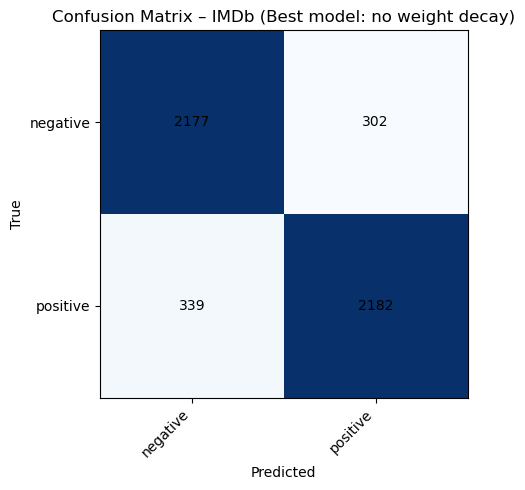

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

label_names = sorted(df["true_name"].unique())

y_true = df["true"].tolist()
y_pred = df["pred"].tolist()

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45, ha="right")
ax.set_yticklabels(label_names)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix – IMDb (Best model: no weight decay)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


### 4.4 Conclusion – Analyse des erreurs

Dans cette section, nous analysons les erreurs commises par notre **meilleur modèle** (configuration *no weight decay*), à partir :

* du tableau des erreurs,
* de la **confusion matrix**,
* et des exemples mal classés.

Malgré des performances très solides (**F1-macro ≈ 0.8718**, accuracy ≈ 0.87), certaines tendances d’erreurs apparaissent clairement, en particulier une confusion marquée entre les classes **positive** et **negative**.


#### **Principaux enseignements**

##### **1) Confusion dominante : Positive → Negative**

C’est la confusion la plus fréquente, ce qu’illustrent les exemples fournis :

* un grand nombre de critiques **positives** sont classées **négatives**,
* la plupart de ces textes contiennent :

  * un langage émotionnel complexe,
  * des descriptions ambiguës,
  * un ton narratif difficile à interpréter automatiquement.

**Pourquoi ?**

* Les critiques positives contiennent souvent des phrases négatives dans un contexte d’ironie ou de comparaison.
* Le LSTM est sensible au vocabulaire isolé :
  *scary, dark, violence, tragic, blood, nightmare…*
  → ce vocabulaire peut déclencher une prédiction *negative*, même si l’opinion globale est positive.
* Certaines critiques sont rédigées sous forme de **récits longs**, ce qui dilue les éléments clairement positifs.

le modèle manque parfois de compréhension globale du sentiment du texte, et se focalise trop sur les mots à polarité négative.


##### **2) Confusion inverse : Negative → Positive**

On observe également un nombre non négligeable de cas **negative → positive**, bien que moins fréquent.

Causes typiques :

* critiques négatives écrites de façon humoristique ou sarcastique,
* textes où l’auteur commence par décrire positivement un film avant de critiquer fortement la fin,
* style d’écriture trop subtil pour un modèle LSTM (nécessité d’un modèle plus contextuel).


#### **3) Analyse de la matrice de confusion**

La matrice montre :

|               | Pred: Neg | Pred: Pos |
| ------------- | --------- | --------- |
| **True: Neg** | **2177**  | 302       |
| **True: Pos** | 339       | **2182**  |

Observations :

##### **a) Bonne séparation globale**

Les deux classes sont relativement équilibrées et bien séparées.

##### **b) Léger biais vers la classe positive**

Le modèle prédit *positive* un peu plus souvent que *negative*.
Il suffit de comparer :

* False Positives = **302**
* False Negatives = **339**

Le modèle commet un peu plus d’erreurs dans le sens *positive → negative*, ce qui reflète la dominance des phrases ambiguës dans les critiques positives.

##### **c) Niveau d’erreur cohérent**

Les ~640 erreurs sur 4000 exemples correspondent à une performance très raisonnable pour un LSTM, surtout **sans weight decay**.


#### **4) Exemples d’erreurs typiques : Positive → Negative**

Les extraits fournis montrent :

##### **Exemple 1**

> *One of the most underrated movies I’ve seen…*
> *OR… you see brilliantly downplayed idiots…*

Vocabulaire mixé, ironie, humour → le modèle se perd.

##### **Exemple 2**

> *When a rich tycoon is killed in a plane crash…*
> *family drama, manipulation, death…*

Beaucoup de termes sombres → classification *negative* compréhensible.

##### **Exemple 3**

> *I originally saw this movie as a boy… I had nightmares… blood lusting ghosts…*

Même si l’avis est positif, le champ lexical de l’horreur trompe le modèle.

**Le modèle manque de compréhension contextuelle globale.**


### **Conclusion**

L’analyse des erreurs montre que :

* Le LSTM reste performant mais **limité** par sa compréhension locale du texte :

  * il réagit fortement à des mots isolés,
  * il peine avec l’ironie, l’humour, et les longues critiques descriptives.
* Les erreurs proviennent majoritairement de **critiques positives contenant du vocabulaire négatif**, ce qui trompe l’algorithme.
* La confusion inverse (negative → positive) reste plus rare mais survient dans les textes sarcastiques.

### **Pour améliorer ces résultats :**

* utiliser un modèle **Transformer** (DistilBERT, BERT, RoBERTa),
* incorporer du **context windowing** ou un pooling plus intelligent,
* intégrer de la **data augmentation textuelle** (EDA, synonym replacement),
* utiliser un **scheduler** pour stabiliser l’entraînement.

Cette analyse clôt la partie *M4 – Analyse d’erreurs* pour IMDb.